7-1 여러 개의 이미지를 분류하는 다층 신경망을 만듭니다

In [ ]:
class MultiClassNetwork():

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z1 = np.dot(x, self.w1) + self.b1
    self.a1 = self.sigmoid(z1)
    z2 = np.dot(self.a1, self.w2) + self.b2
    return z2
  
  def backprop(self, x, err):
    m = len(x)
    w2_grad = np.dot(self.a1.T, err) / m
    b2_grad = np.sum(err) / m
    err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
    w1_grad = np.dot(x.T, err_to_hidden) / m
    b1_grad = np.sum(err_to_hidden, axis=0) / m
    return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def softmax(self, z):
    exp_z = np.exp(z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)

  def init_weights(self, n_features, n_classes):
    self.w1 = np.random.normal(0, 1,
                               (n_features, self.units))
    self.b1 = np.zeros(self.units)
    self.w2 = np.random.normal(0, 1,
                               (self.units, n_classes))
    self.b2 = np.zeros(n_classes)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    np.random.seed(42)
    self.init_weights(x.shape[1], y.shape[1])
    for i in range(epochs):
      loss = 0
      print('.', end='')
      for x_batch, y_batch in self.gen_batch(x, y):
        a = self.training(x_batch, y_batch)
        a = np.clip(a, 1e-10, 1-1e-10)
        loss += np.sum(-y_batch * np.log(a))
      self.losses.append((loss + self.reg_loss()) / len(x))
      self.update_val_loss(x_val, y_val)
  
  def gen_batch(self, x, y):
    length = len(x)
    bins = length // self.batch_size
    if length % self.batch_size:
      bins += 1
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

  def training(self, x, y):
    m = len(x)
    z = self.forpass(x)
    a = self.softmax(z)
    err = -(y - a)
    w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
    w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
    w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

    self.w1 -= self.lr * w1_grad
    self.b1 -= self.lr * b1_grad

    self.w2 -= self.lr * w2_grad
    self.b2 -= self.lr * b2_grad
    return a

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z, axis=1)

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def reg_loss(self):
    return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
           self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
    z = self.forpass(x_val)
    a = self.softmax(z)
    a = np.clip(a, 1e-10, 1-1e-10)
    val_loss = np.sum(-y_val * np.log(a))
    self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

In [ ]:
!pip install tensorflow_gpu==2.0.0

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.0.0'

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


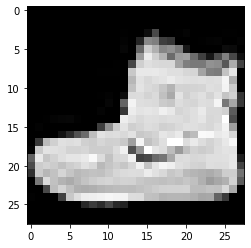

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [ ]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [ ]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [ ]:
print(class_names[y_train_all[0]])

앵클부츠


In [ ]:
import numpy as np
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [ ]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [ ]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [ ]:
x_trian = x_train / 255
x_val = x_val / 255

In [ ]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [ ]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [ ]:
tf.keras.utils.to_categorical([0,1,3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [ ]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [ ]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)

.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp


.......................................

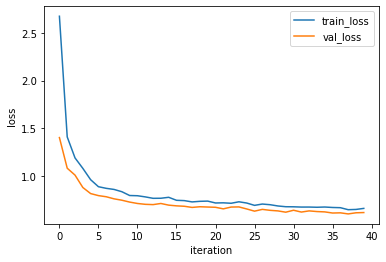

In [ ]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
fc.score(x_val, y_val_encoded)

0.7675

7-2 텐서플로와 케라스를 사용하여 신경망을 만듭니다

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()

In [ ]:
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 7s 138us/sample - loss: 1.0683 - accuracy: 0.6691 - val_loss: 1.3667 - val_accuracy: 0.6119
Epoch 2/40
48000/48000 [==============================] - 6s 115us/sample - loss: 0.7335 - accuracy: 0.7506 - val_loss: 1.1505 - val_accuracy: 0.6519
Epoch 3/40
48000/48000 [==============================] - 5s 112us/sample - loss: 0.7089 - accuracy: 0.7524 - val_loss: 1.0301 - val_accuracy: 0.6977
Epoch 4/40
48000/48000 [==============================] - 6s 117us/sample - loss: 0.6901 - accuracy: 0.7600 - val_loss: 0.9376 - val_accuracy: 0.7132
Epoch 5/40
48000/48000 [==============================] - 6s 118us/sample - loss: 0.6729 - accuracy: 0.7603 - val_loss: 0.8771 - val_accuracy: 0.7327
Epoch 6/40
48000/48000 [==============================] - 5s 114us/sample - loss: 0.6498 - accuracy: 0.7654 - val_loss: 0.8069 - val_accuracy: 0.7548
Epoch 7/40
48000/48000 [==========================

In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


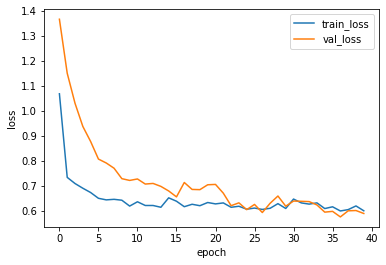

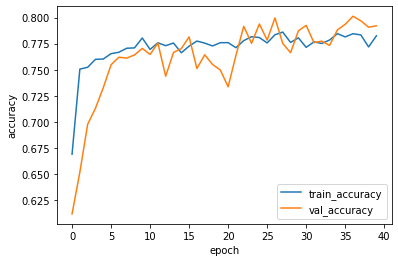

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.7920833
